# The Moving Averages Crossover Strategy - 

* A possible trend reversal opens up an opportunity for initiating a trade.
* In this notebook, we shall leverage moving averages to identify a change in trend for any given ticker. 
* The Moving Averages crossover strategy involves the use of a longer-term (n) MA and a shorter-term MA (m) for the same chart.
* The shorter-term MAs will help us capture the short-term changes in stock prices whereas the longer-term MAs will help us keep track of stock prices over a longer period. 
* As a result, the strategy gives a buy signal when the shorter-term MA crosses above the longer-term MA, indicating an upward trend for the stock prices. This crossover is also known as a Golden cross.  
* Similarly, the strategy gives a signal to sell when the shorter-term MA crosses below the longer-term MA, indicating a downward trend for the stock prices. This cross is also known as the Death cross.

<img src='./images/ma_crossover_cover.png'>

In [1]:
import os
import sys

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import mplfinance as mpl
import numpy as np
import seaborn as sns


from notebook_utils import initialize_environment, print_heading, Color

initialize_environment()


from analytics.strategies.ma_crossovers import MAStrategy, Trend
from analytics.studies.moving_averages import MAModels
from analytics.services.alpha_vantage import TimeInterval, AVTimeseries
from analytics.services.alpha_vantage_utils import OutputSize


cm = sns.light_palette("green", as_cmap=True)

%load_ext nb_black

<IPython.core.display.Javascript object>

# 5 simple steps to evaluate the MA strategy for any Ticker - 

1. Load the data. 
2. Compute Moving Averages.
3. Annotate Sessions and Compute Returns.
4. Visualize & Analyze estimated returns
5. Make an informed decision. 

## Preflight -

* Let us start by looking up for the correct ticker symbol using Alpha vantage. 

In [2]:
# if you dont have an alpha vantage api_key get it from -
# https://www.alphavantage.co/support/#api-key
av_obj = AVTimeseries(api_key="<AV_API_KEY>")

search_keyword = "microsoft"

search_symbol_results_df = av_obj.get_symbol_search_results(
    search_keyword=search_keyword
)
search_symbol_results_df.style.background_gradient(cmap=cm)

,symbol,name,type,region,marketOpen,marketClose,timezone,currency,matchScore
0,MSFT,Microsoft Corporation,Equity,United States,09:30,16:00,UTC-05,USD,0.6154
1,MSF.DEX,Microsoft Corporation,Equity,XETRA,08:00,20:00,UTC+01,EUR,0.6000
2,MSF.FRK,Microsoft Corporation,Equity,Frankfurt,08:00,20:00,UTC+01,EUR,0.6000
3,MSFT34.SAO,Microsoft Corporation,Equity,Brazil/Sao Paolo,10:00,17:30,UTC-03,BRL,0.6000


<IPython.core.display.Javascript object>

### Pick the correct symbol from search results

* From here on, we shall use symbol 'MFST' (first row from the search results) to demonstrate computation further. 

In [3]:
symbol = search_symbol_results_df["symbol"].iloc[0]
print(symbol)

# Lets grab daily for MFST.

av_ticker_df = av_obj.get_daily_data(
    symbol=symbol, outputsize=OutputSize.FULL, adjusted=True, last_ten_years_only=True
)
av_ticker_df.index = pd.to_datetime(av_ticker_df.index)
display(av_ticker_df.head().style.background_gradient(cmap=cm))

MSFT


,open,high,low,close,adjusted close,volume,dividend amount,split coefficient
2011-02-28 00:00:00,26.690000,26.860000,26.510000,26.580000,21.258217,51379900.000000,0.000000,1.000000
2011-03-01 00:00:00,26.600000,26.780000,26.150000,26.160000,20.922309,60055000.000000,0.000000,1.000000
2011-03-02 00:00:00,26.110000,26.370000,26.040000,26.077500,20.856327,48658200.000000,0.000000,1.000000
2011-03-03 00:00:00,26.260000,26.400000,26.180000,26.200000,20.954300,68271500.000000,0.000000,1.000000
2011-03-04 00:00:00,26.220000,26.240000,25.800000,25.952500,20.756354,70437200.000000,0.000000,1.000000


<IPython.core.display.Javascript object>

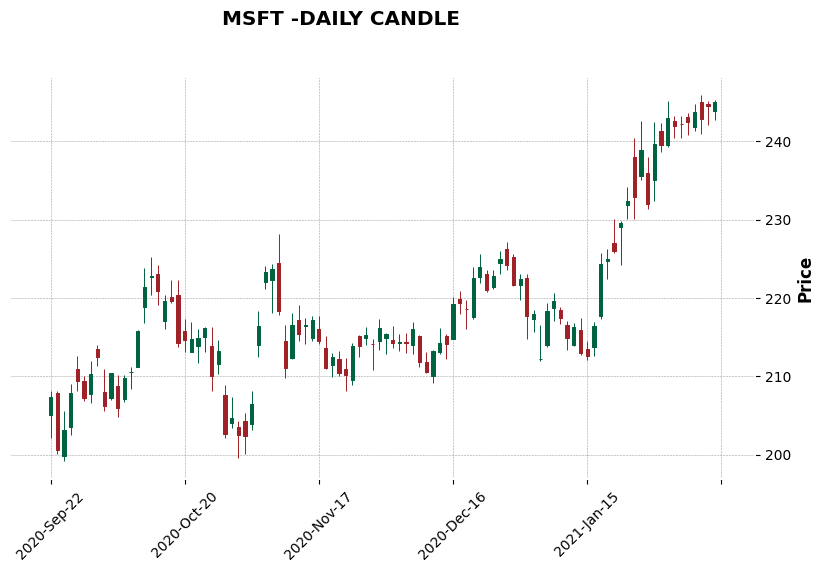

<IPython.core.display.Javascript object>

In [4]:
mpl.plot(
    av_ticker_df[-100:],
    type="candle",
    style="charles",
    figratio=(18, 10),
    title=f"{symbol} -DAILY CANDLE",
)

# 2. Compute Moving Averages

* In this section, I have used the exponential weighted moving averages. 

In [5]:
# Bottom up approach - Lets us evaluate how profitable 20-10 SMA cross-over strategy for MFST is.
# It is same simple as pasisng the correct dataframe and defining the slower moving average time period
# and faster moving time period.
# SO lets get to it.

# Ensure that slow_ma is greater than fast_ma. It makes logical sense.
# If slow_ma < fast_ma, there will be an AssertionError
ma_strategy_df = MAStrategy.evaluate_ma_crossover(
    ticker_df=av_ticker_df,
    slow_ma=20,
    fast_ma=10,
    capture_trend=Trend.BULLISH,
    ma_model=MAModels.EWMA,
)

display(
    ma_strategy_df.tail(20).style.bar(
        subset=["percent_returns"], align="mid", color=["#d65f5f", "#5fba7d"]
    )
)

,,percent_returns,session_details
ma_session_20_10,label_20_10,,
71,bullish,15.792966,2016-10-21 00:00:00-2017-06-28 00:00:00
73,bullish,26.764747,2017-07-12 00:00:00-2018-02-07 00:00:00
75,bullish,1.392391,2018-02-15 00:00:00-2018-03-21 00:00:00
77,bullish,7.194634,2018-04-12 00:00:00-2018-06-26 00:00:00
79,bullish,12.383622,2018-07-06 00:00:00-2018-10-09 00:00:00
81,bullish,-1.994633,2018-11-08 00:00:00-2018-11-09 00:00:00
83,bullish,-3.897399,2018-11-29 00:00:00-2018-12-14 00:00:00
85,bullish,19.447083,2019-01-16 00:00:00-2019-05-30 00:00:00
87,bullish,5.967954,2019-06-07 00:00:00-2019-08-02 00:00:00


<IPython.core.display.Javascript object>

# 3. Visualize and Analyze results - 

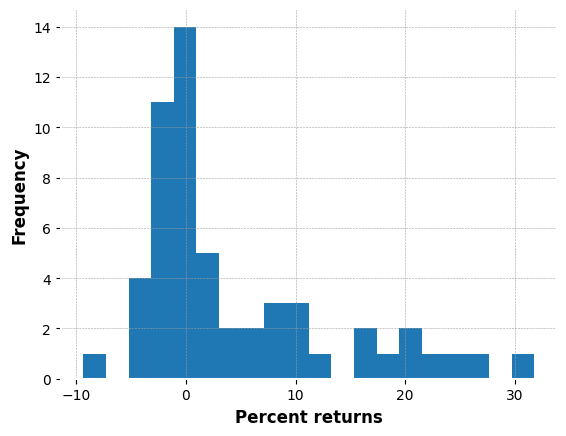

  Estimated Expected returns (%) - 4.394559449090707 % 


<IPython.core.display.Javascript object>

In [6]:
ax = ma_strategy_df.percent_returns.hist(bins=20)

ax.set_xlabel("Percent returns")
ax.set_ylabel("Frequency")

plt.show()

expected_returns = ma_strategy_df.percent_returns.mean()

color = Color.GREEN if expected_returns > 0 else Color.RED

print(
    f"{Color.BOLD} {color} Estimated Expected returns (%) - {expected_returns} % {Color.END}"
)

### Top-to-Bottom approach 


* The current implementation of Toucan also allows us to perform the analysis with more granular control. 
* In this section, we shall evaluate the Moving Average strategy using Simple Moving Averages.

In [7]:
# define slow and fast moving average look back periods
# Again, ensure that slow_ma > fast_ma
slow_ma = 20
fast_ma = 10
capture_trend = Trend.BULLISH

# create an instance of SMAStrategy
ma_strategy_obj = MAStrategy(ticker_df=av_ticker_df, slow_ma=20, fast_ma=10)


# compute simple moving averages
ma_df = ma_strategy_obj.compute_sma(look_back_periods=[10, 20])
print_heading("Moving Averages")
display(ma_df.head(10).style.background_gradient(cmap=cm))


# we can club the computation of SMA and annotattion using the sma_sessions method as well
ma_sessions_annotated_df = ma_strategy_obj.ma_sessions()

print_heading("Moving Average Cross Over Strategy Annotated Sessions")
display(ma_sessions_annotated_df.head().style.background_gradient(cmap=cm))

# use annotated sessions data to compute percentage returns
column_suffix = f"{slow_ma}_{fast_ma}"
summary_df = ma_sessions_annotated_df.groupby(
    [f"ma_session_{column_suffix}", f"label_{column_suffix}"], as_index=True
).apply(MAStrategy.compute_returns, slow_ma=slow_ma, fast_ma=fast_ma)

if capture_trend in {Trend.BULLISH, Trend.BEARISH}:
    summary_df = summary_df.loc[
        summary_df.index.get_level_values("label_20_10") == capture_trend.value
    ]

print_heading("Returns Summary")

display(
    summary_df.tail(20).style.bar(
        subset=["percent_returns"], align="mid", color=["#d65f5f", "#5fba7d"]
    )
)

###############################

Moving Averages

###############################


,ma_10,ma_20
2011-02-28 00:00:00,26.580000,26.580000
2011-03-01 00:00:00,26.160000,26.160000
2011-03-02 00:00:00,26.077500,26.077500
2011-03-03 00:00:00,26.200000,26.200000
2011-03-04 00:00:00,25.952500,25.952500
2011-03-07 00:00:00,25.720000,25.720000
2011-03-08 00:00:00,25.910000,25.910000
2011-03-09 00:00:00,25.890000,25.890000
2011-03-10 00:00:00,25.410000,25.410000
2011-03-11 00:00:00,25.958000,25.680000


###############################

Moving Average Cross Over Strategy Annotated Sessions

###############################


,open,high,low,close,adjusted close,volume,dividend amount,split coefficient,ma_20,ma_10,ma_signal_20_10,ma_session_20_10,label_20_10
2011-02-28 00:00:00,26.690000,26.860000,26.510000,26.580000,21.258217,51379900.000000,0.000000,1.000000,26.580000,26.580000,False,0,bearish
2011-03-01 00:00:00,26.600000,26.780000,26.150000,26.160000,20.922309,60055000.000000,0.000000,1.000000,26.160000,26.160000,False,0,bearish
2011-03-02 00:00:00,26.110000,26.370000,26.040000,26.077500,20.856327,48658200.000000,0.000000,1.000000,26.077500,26.077500,False,0,bearish
2011-03-03 00:00:00,26.260000,26.400000,26.180000,26.200000,20.954300,68271500.000000,0.000000,1.000000,26.200000,26.200000,False,0,bearish
2011-03-04 00:00:00,26.220000,26.240000,25.800000,25.952500,20.756354,70437200.000000,0.000000,1.000000,25.952500,25.952500,False,0,bearish


###############################

Returns Summary

###############################


,,percent_returns,session_details
ma_session_20_10,label_20_10,,
87,bullish,1.180223,2018-04-13 00:00:00-2018-05-04 00:00:00
89,bullish,2.649974,2018-05-08 00:00:00-2018-06-25 00:00:00
91,bullish,4.174370,2018-07-12 00:00:00-2018-08-22 00:00:00
93,bullish,0.528342,2018-08-30 00:00:00-2018-10-09 00:00:00
95,bullish,-5.430033,2018-11-13 00:00:00-2018-11-20 00:00:00
97,bullish,-2.768853,2018-12-06 00:00:00-2018-12-17 00:00:00
99,bullish,3.307164,2019-01-14 00:00:00-2019-02-07 00:00:00
101,bullish,17.326686,2019-02-14 00:00:00-2019-05-14 00:00:00
103,bullish,0.279151,2019-05-29 00:00:00-2019-05-30 00:00:00


<IPython.core.display.Javascript object>

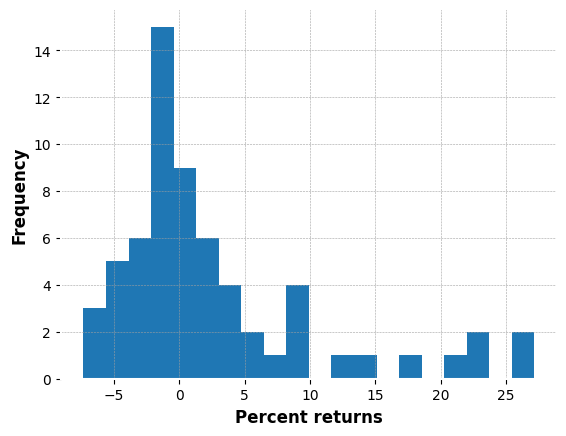

  Estimated Expected returns (%) - 2.7059986828708382 % 


<IPython.core.display.Javascript object>

In [8]:
ax = summary_df.percent_returns.hist(bins=20)

ax.set_xlabel("Percent returns")
ax.set_ylabel("Frequency")

plt.show()

expected_returns = summary_df.percent_returns.mean()

color = Color.GREEN if expected_returns > 0 else Color.RED

print(
    f"{Color.BOLD} {color} Estimated Expected returns (%) - {expected_returns} % {Color.END}"
)
